In [1]:
# Program to plot XBT profiles from NSF-PEACH
#
# Joseph B. Zambon
# 25 September 2017

In [2]:
# import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import datetime
from scipy import signal
from scipy.io import loadmat
import numpy.fft as fft
import numpy as np
import os
import csv
import urllib
import netCDF4
import datetime
from pydap.client import open_url


In [19]:
csv_path = './'
z_matfile = './useast_z.mat'
max_depths = np.array([117, 219, 201, 218, 246, 180, 320, 200, 250, 140, 250, 254]) *-1
usgs_bathy = False

In [20]:
# For inline plotting
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [21]:
# Load files
files = []
files= sorted([ file for file in os.listdir(csv_path)])

files_size = len(files)
i=0
while i < files_size:
    if not files[i].endswith(".edf"):
        del files[i]
        files_size -= 1
    else:
        i += 1

In [22]:
# Read in all data
mm_ar = []
dd_ar = []
yyyy_ar = []
hh_ar = []
mi_ar = []
latd_ar = []
latm_ar = []
lond_ar = []
lonm_ar = []
temp_ar = []

for file in range(0,len(files)):
    row = 0
    num_rows = 0
    total_rows = 0
    t_rows = 0
    temp = []
    with open(files[file], 'rb') as csvfile:
        spamreader = csv.reader(csvfile, delimiter='\t')
        for row in spamreader:
            if num_rows == 2:
                mm=np.char.strip(row[0][17:19]).astype(np.int)
                dd=np.char.strip(row[0][20:22]).astype(np.int)
                yyyy=np.char.strip(row[0][23:28]).astype(np.int)
            if num_rows == 3:
                hh=np.char.strip(row[0][17:19]).astype(np.int)
                mi=np.char.strip(row[0][20:22]).astype(np.int)
                #print np.char.strip(row).astype(np.float)
            if num_rows == 5:
                latd=np.char.strip(row[0][17:19]).astype(np.int)
                latm=np.char.strip(row[0][20:28],'N').astype(np.float)            
            if num_rows == 6:
                lond=np.char.strip(row[0][17:19]).astype(np.int)*-1
                lonm=np.char.strip(row[0][20:28],'W').astype(np.float)
            if num_rows > 31:
                #print row
                temp.append(np.char.strip(row[0]).astype(np.float))
                temp.append(np.char.strip(row[1]).astype(np.float))
                temp.append(np.char.strip(row[2]).astype(np.float))
                t_rows = t_rows +1
            num_rows = num_rows +1
        temp = np.reshape(temp, (t_rows,3))
        mm_ar.append(mm)
        dd_ar.append(dd)
        yyyy_ar.append(yyyy)
        hh_ar.append(hh)
        mi_ar.append(mi)
        latd_ar.append(latd)
        latm_ar.append(latm)
        lond_ar.append(lond)
        lonm_ar.append(lonm)
        temp_ar.append(temp)

In [23]:
if usgs_bathy == True:
    # Eliminate data below USGS 30s bathymetry depth
    # Definine the domain of interest
    coords = [43, 30, -65, -82]
    isub = 1   #subsample spacing
    bathy_file='peach_domain.nc'

    base_url='http://coastwatch.pfeg.noaa.gov/erddap/griddap/usgsCeSrtm30v6.nc?'
    query='topo[(%f):%d:(%f)][(%f):%d:(%f)]' % (coords[0],isub,coords[1],coords[3],isub,coords[2])
    url = base_url+query
    print url

    # store data in NetCDF file
    urllib.urlretrieve (url, bathy_file)
    # open NetCDF data in 
    nc = netCDF4.Dataset(bathy_file)
    ncv = nc.variables
    print ncv.keys()

    lon = ncv['longitude'][:]
    lat = ncv['latitude'][:]
    lons, lats = np.meshgrid(lon,lat)
    topo = ncv['topo'][:,:]
    

In [24]:
def dm2decdeg(deg,mnt):
    is_positive = deg >= 0
    dd = abs(deg)
    dd_int = int(deg)
    dd_dec = (mnt)/60
    dd = dd_int+dd_dec if is_positive else -dd-dd_dec
    return(dd)

In [25]:
roms_cnaps_url = 'http://oceanus.meas.ncsu.edu:8080/thredds/dodsC/fmrc/useast_coawst_roms/COAWST-ROMS_SWAN_Forecast_Model_Run_Collection_best.ncd'
roms_dataset = open_url(roms_cnaps_url)
#print('')
#print('')
#print('Available ROMS/SWAN data:')
#print(roms_dataset.keys)
#Find ROMS time indices
roms_origin_date = datetime.datetime(2013,8,30,0,0,0)
roms_time=(np.array(roms_dataset['time'][:]))/24+datetime.date.toordinal(roms_origin_date)

In [26]:
roms_lon=np.array(roms_dataset['lon_rho'])
roms_lat=np.array(roms_dataset['lat_rho'])
roms_z=loadmat(z_matfile)
roms_z=roms_z['z_r']
print roms_z.shape
roms_z=numpy.flipud(roms_z)

(36, 482, 402)


In [27]:
# Function to find nearest ROMS X,Y point
def findxy_roms(lon1,lat1,lon,lat):
    dis=np.sqrt(square(np.subtract(lon,lon1))+square(np.subtract(lat,lat1)))
    from numpy import unravel_index
    index=unravel_index(dis.argmin(), dis.shape)
    jj=index[0]
    ii=index[1]
    return jj,ii

In [28]:
# # Find location of transect points on ROMS grid roms_loc=np.zeros([len(xbt_files),2])
# roms_index=0
# i=1
# for i in xrange(0,len(files)):
#     roms_loc[roms_index,:]=findxy_roms(xbt_pos[i,2],xbt_pos[i,1],lon,lat)
#     roms_index=roms_index+1
#     roms_loc=array(roms_loc).astype(int)

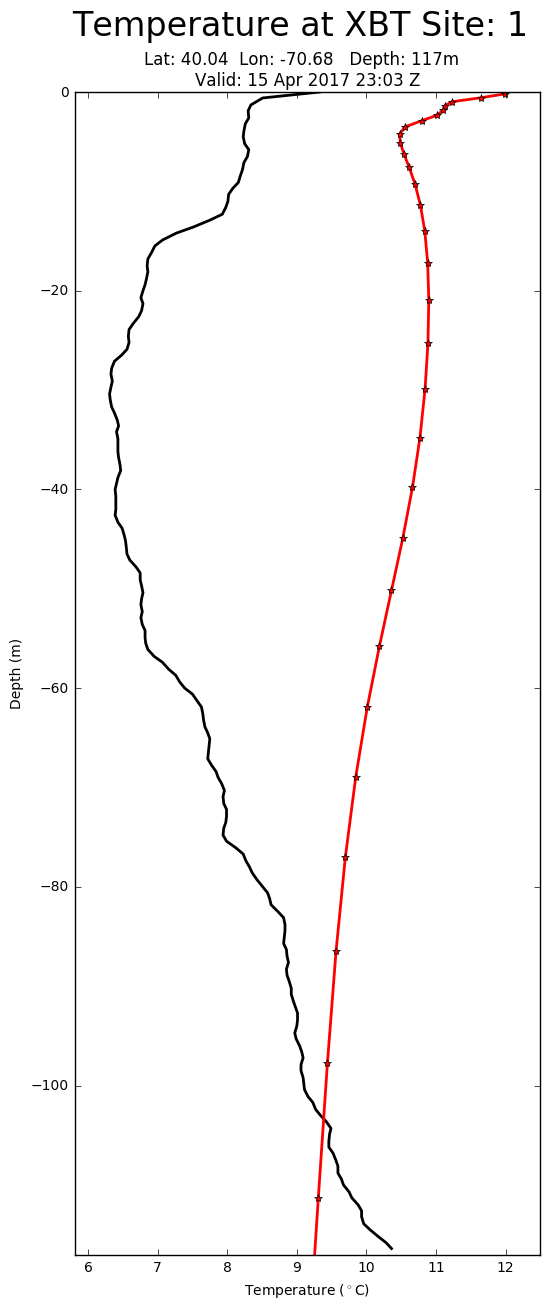

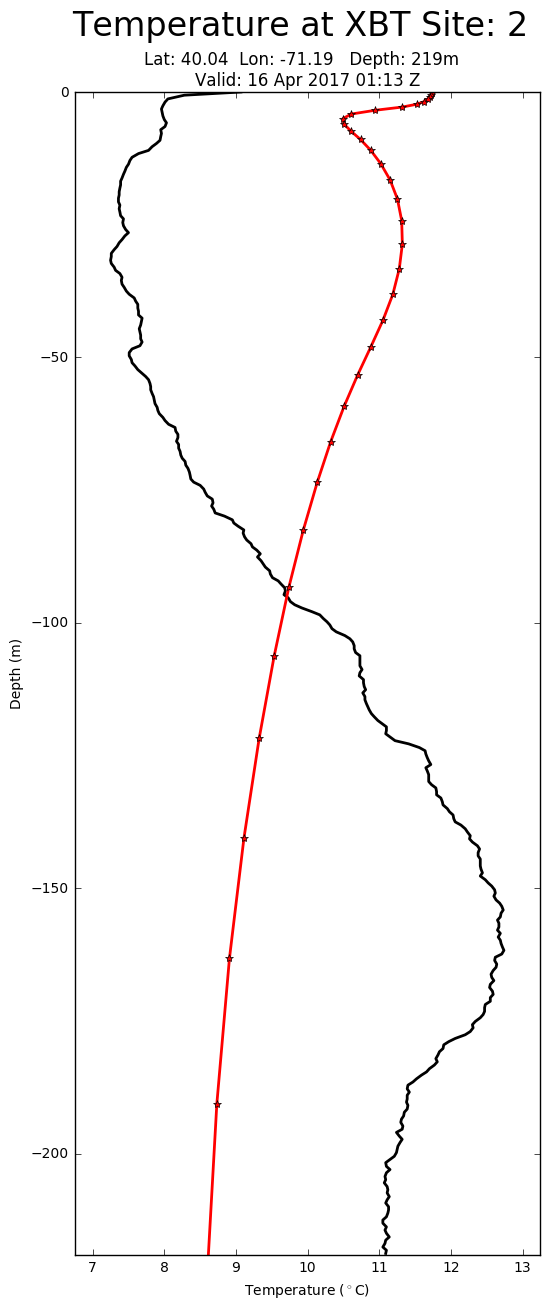

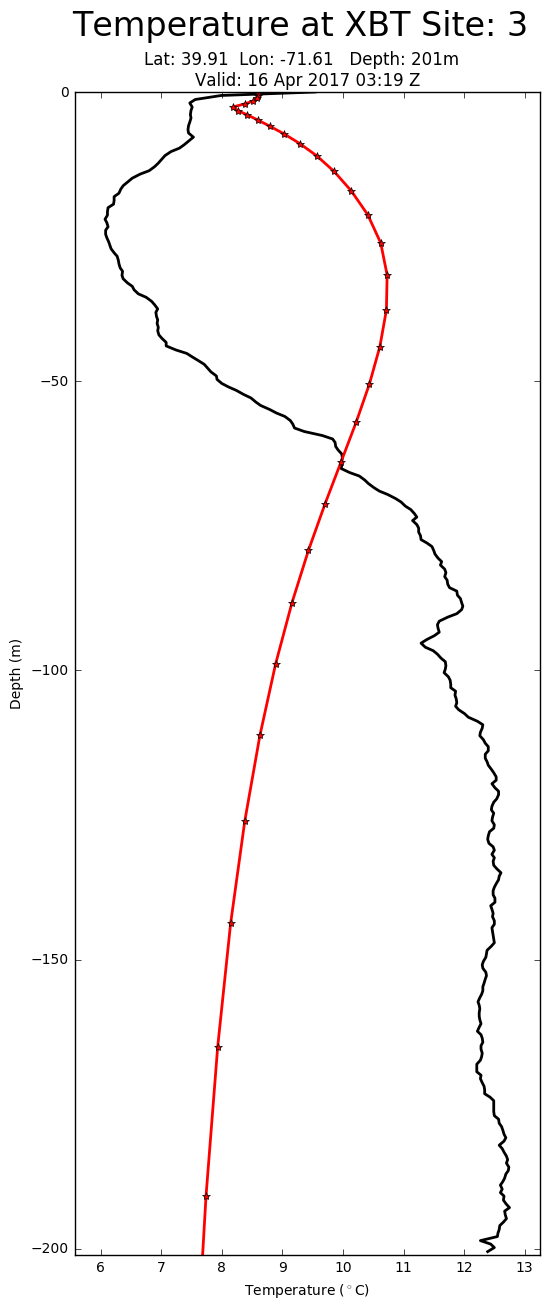

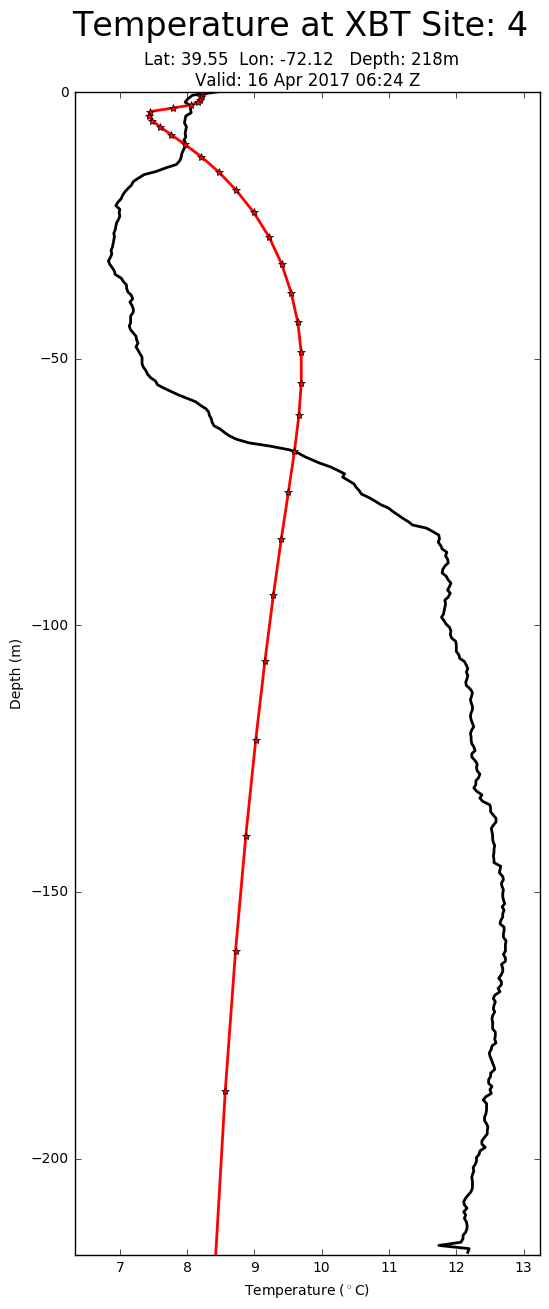

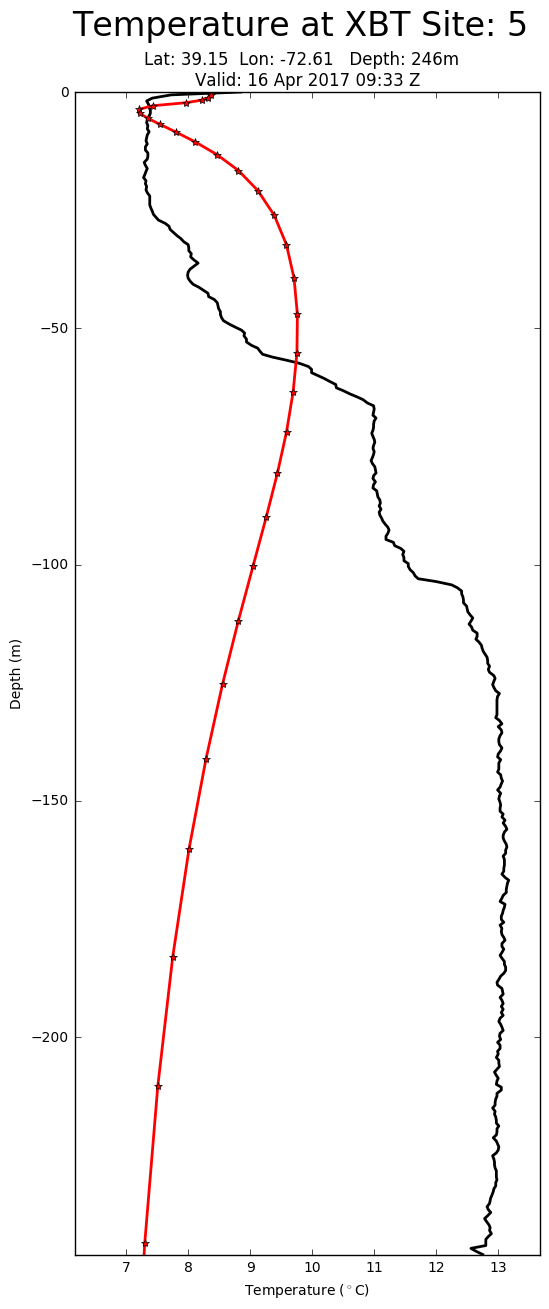

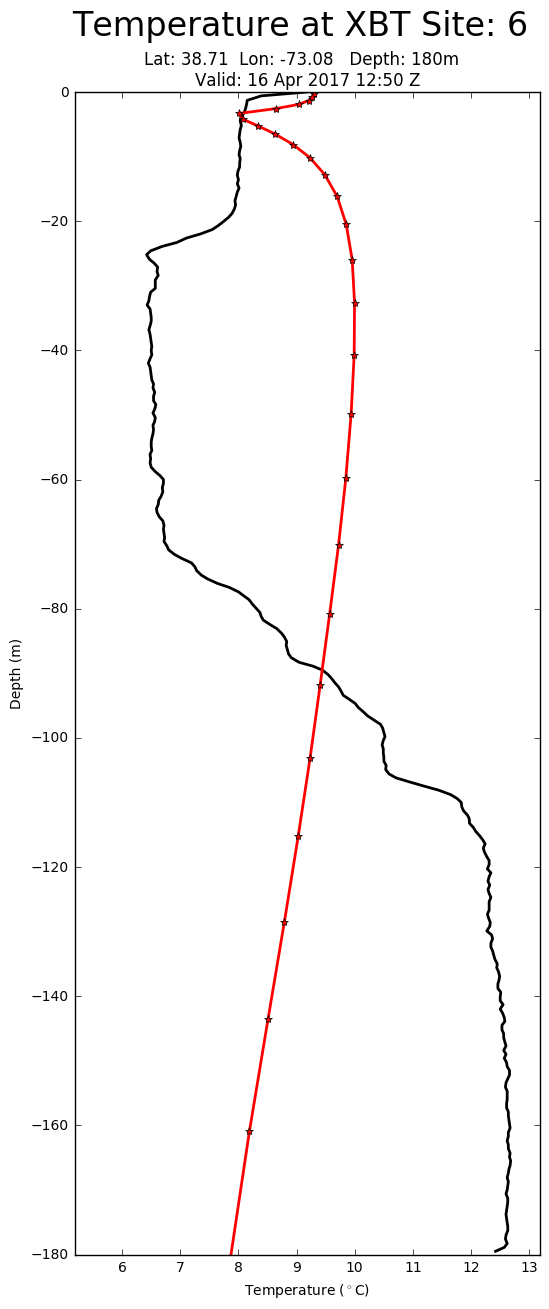

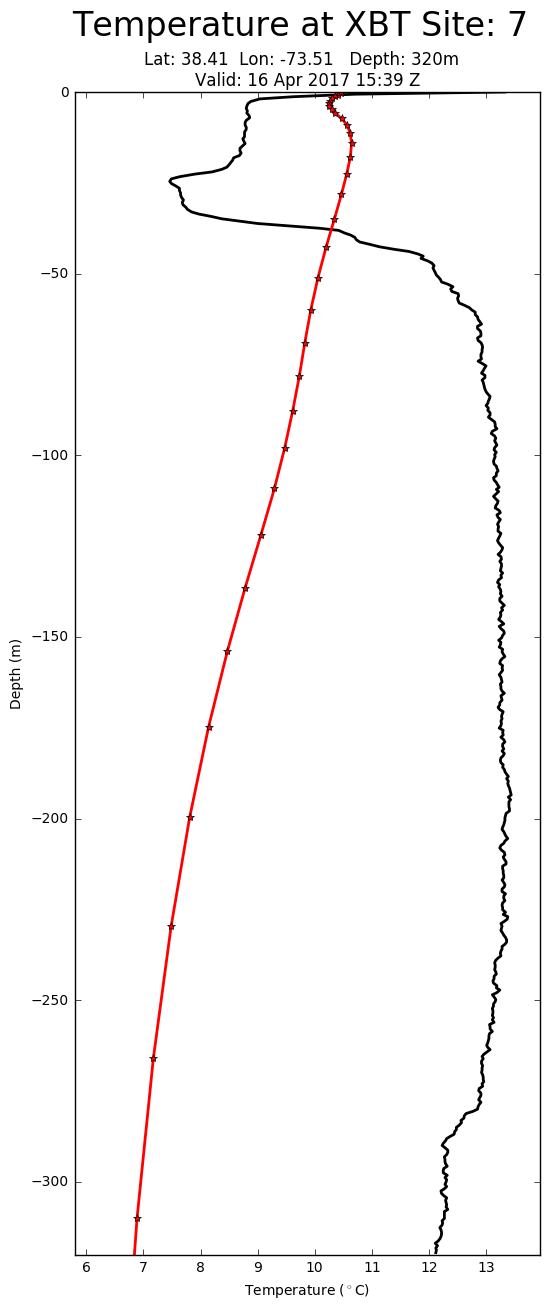

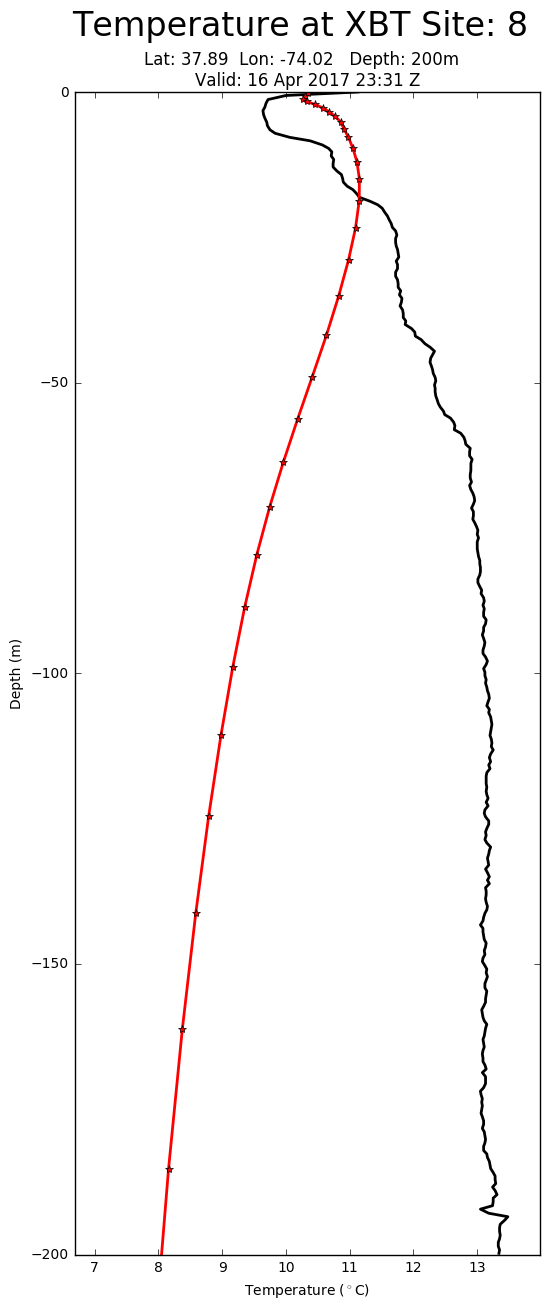

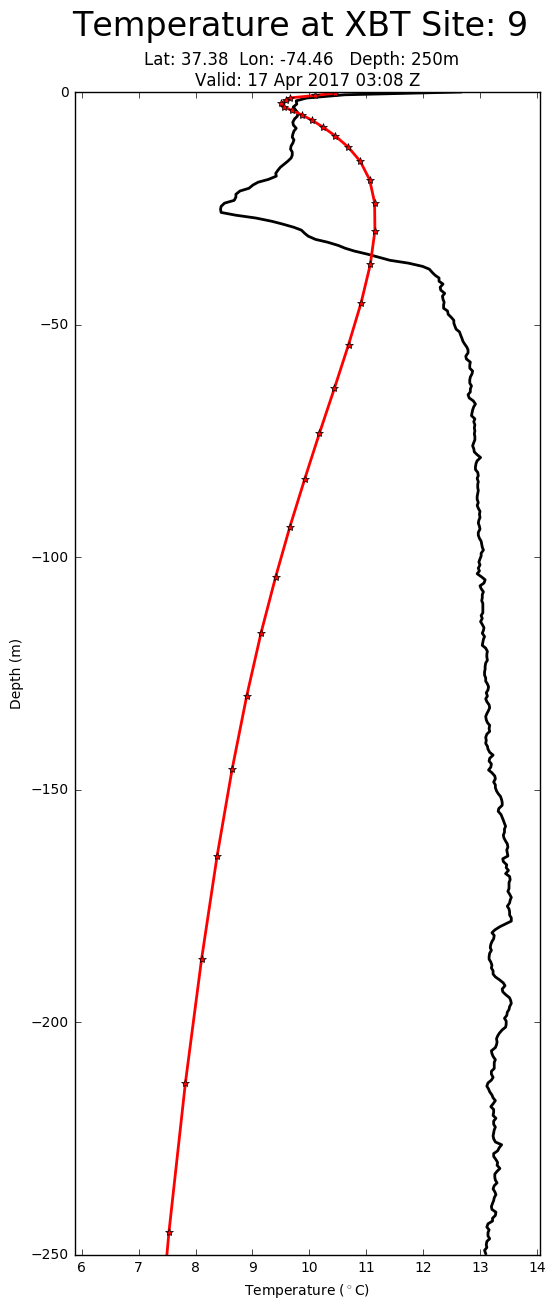

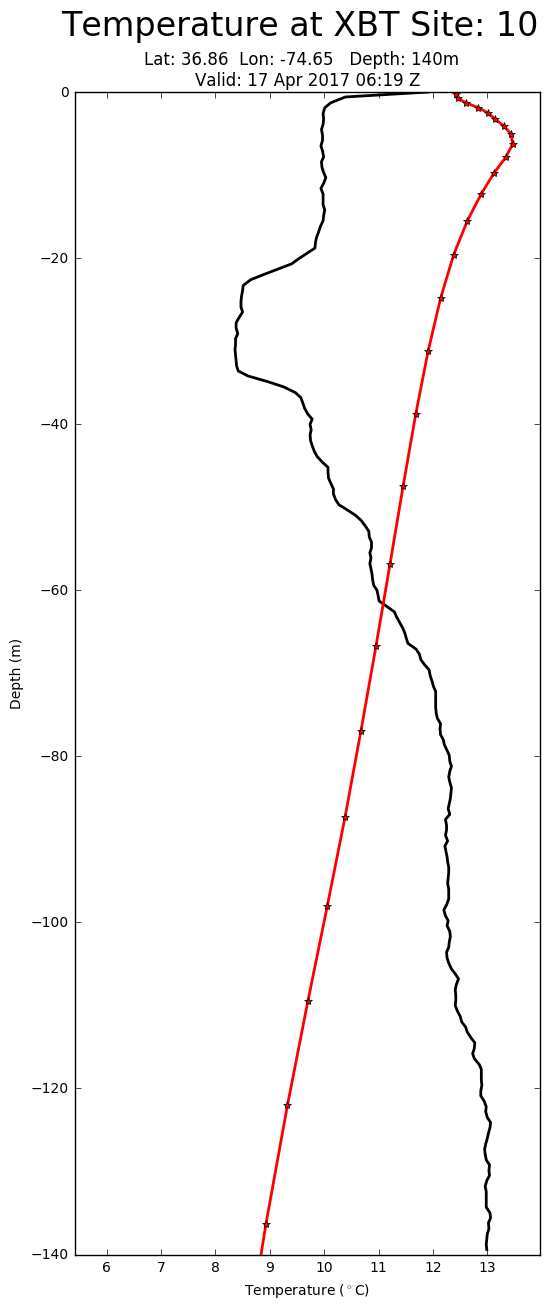

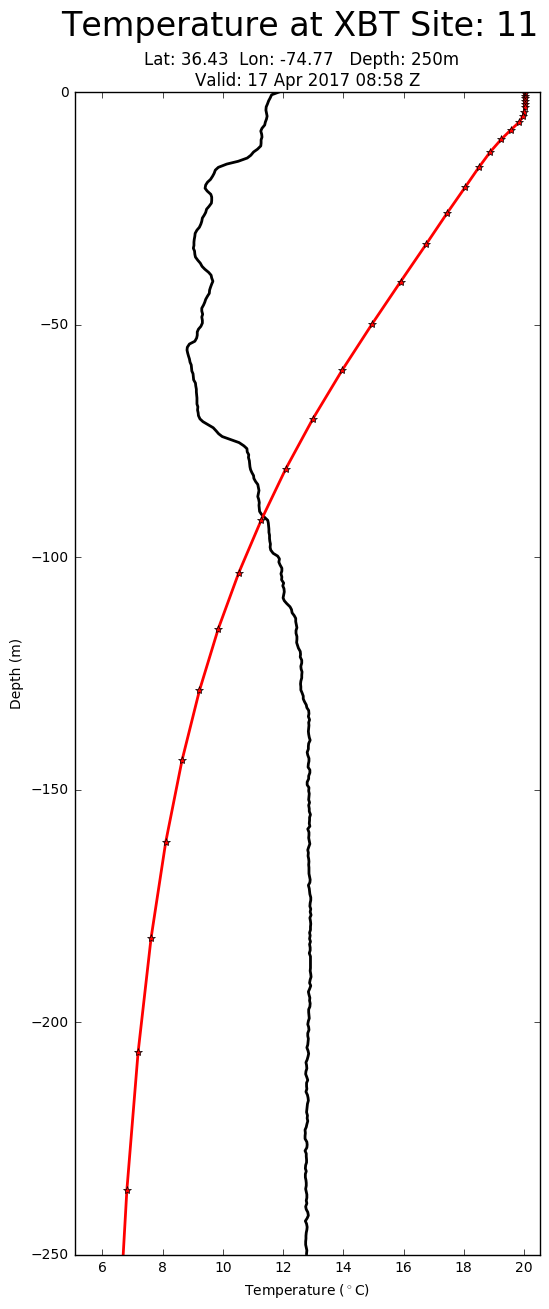

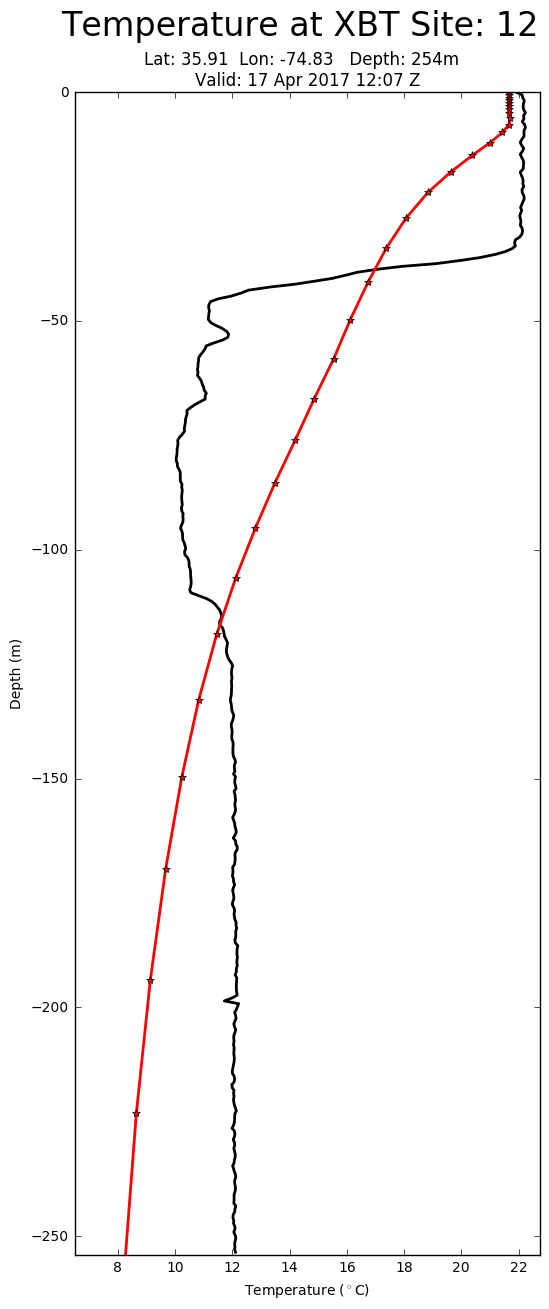

In [29]:
temp = []
depth = []
for file in range(0,len(files)):
#for file in range(0,1):
    fig, ax = plt.subplots(1,1,figsize=(6,15))
    #XBT Profile
    profile = temp_ar[file][:][:]
    p_depth = profile[:,0]*-1
    p_temp = profile[:,1]
    p_lat = dm2decdeg(latd_ar[file],latm_ar[file])
    p_lon = dm2decdeg(lond_ar[file],lonm_ar[file])
    yyyy = yyyy_ar[file]; mm = mm_ar[file]; dd = dd_ar[file]; hh = hh_ar[file];
    date = datetime.datetime(yyyy_ar[file],mm_ar[file],dd_ar[file],hh_ar[file],mi_ar[file])
    #print date
    p_temp[p_temp<0]=np.nan
    p_temp[p_depth<max_depths[file]]=np.nan
    # ROMS profile
    roms_loc = findxy_roms(p_lon,p_lat,roms_lon,roms_lat)
    roms_t_index = np.where(roms_time==(datetime.date.toordinal(date)+floor(float(date.strftime("%H"))/3)/8))
    roms_t_index = roms_t_index[0][0]    
    r_t = np.array(roms_dataset['temp'][roms_t_index,:,roms_loc[0],roms_loc[1]]);
    r_t = np.squeeze(r_t); r_t = np.flipud(r_t);
    r_z = roms_z[:,roms_loc[0],roms_loc[1]]
#     print file
#     print roms_lon[roms_loc[0],roms_loc[1]];
#     print roms_lat[roms_loc[0],roms_loc[1]];
#     print roms_time[roms_t_index];
    # Plot
    ax.plot(p_temp,p_depth,'-',linewidth=2,color='k')  # XBT Profile
    ax.plot(r_t,r_z,'*-',linewidth=2,color='r')
    ax.axis([min(min(r_t),min(p_temp))-0.5, max(max(r_t),max(p_temp))+0.5, max_depths[file], 0])
    xlabel('Temperature ($^\circ$C)')
    ylabel('Depth (m)')
    plt.suptitle('Temperature at XBT Site: ' + str(file+1),fontsize=24,family='Helvetica',y=.955)
    title('Lat: ' + str(round(p_lat,2)) + '  Lon: ' + str(round(p_lon,2)) + '   Depth: ' \
          + str(max_depths[file]*-1) + 'm  ' + '\nValid: ' + date.strftime("%d %b %Y %H:%M"+" Z"))
    fig.savefig(str(file) + '.png',dpi=100)

In [ ]:
profile = temp_ar[file][:][:]
p_depth = profile[:,0]*-1
p_temp = profile[:,1]
p_lat = dm2decdeg(latd_ar[file],latm_ar[file])
p_lon = dm2decdeg(lond_ar[file],lonm_ar[file])
#bathy_x,bathy_y = np.argmin(abs(lon[:]-p_lon)),np.argmin(abs(lat[:]-p_lat))
#print topo[bathy_y,bathy_x]
p_temp[p_temp<0]=np.nan
#p_temp[p_depth<topo[bathy_y,bathy_x]]=np.nan
print max_depths[file]
p_temp[p_depth<max_depths[file]]=np.nan
ax.plot(p_temp,p_depth,'-',linewidth=2,color='k')
#ax.tick_params(labelbottom='off',labeltop='on')
fig.savefig(str(file) + '.png',dpi=50)
fig.clf()

In [ ]:
np.shape(r_t)